In [2]:
import pandas as pd

#averages
df_averages=pd.read_csv("../data/landing/demographics/2021 Census GCP Statistical Area 2 for VIC/2021Census_G02_VIC_SA2.csv")
#tenure, how many rented etc.
df_structure=pd.read_csv("../data/landing/demographics/2021 Census GCP Statistical Area 2 for VIC/2021Census_G37_VIC_SA2.csv") 
#unemployment 
df_unemployment=pd.read_csv("../data/landing/demographics/2021 Census GCP Statistical Area 2 for VIC/2021Census_G46B_VIC_SA2.csv")
#education
df_education=pd.read_csv("../data/landing/demographics/2021 Census GCP Statistical Area 2 for VIC/2021Census_G49B_VIC_SA2.csv")

First file from census is averages of features per each area, most useful for our analysis 

In [3]:
df_averages.head()

,SA2_CODE_2021,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size
0,201011001,34,1698,865,370,2218,0.8,1952,2.8
1,201011002,45,1700,842,313,2276,0.7,1573,2.2
2,201011005,42,1662,805,330,2270,0.8,1927,2.7
3,201011006,33,1500,775,360,1855,0.7,1627,2.6
4,201011007,41,1733,802,350,2236,0.8,2065,3.0


Extracting the dwelling ownership/structure 

In [4]:
# Keep only columns ending with "_Tot"
df_tot = df_structure.loc[:, df_structure.columns.str.endswith('_Total') | (df_structure.columns == "SA2_CODE_2021")]

# Separate the key column
codes = df_tot[["SA2_CODE_2021"]]

# Divide only the numeric part
df_per = df_tot.drop(columns=["SA2_CODE_2021"]).div(df_tot["Total_Total"], axis=0)

# Reattach the codes
df_per = pd.concat([codes, df_per], axis=1)


rename_map = {
    "SA2_CODE_2021": "SA2_CODE_2021",
    "O_OR_Total": "Owner occupied (%)",
    "O_MTG_Total": "Mortgage (%)",
    "R_Tot_Total": "Total rented (%)",
    "Oth_ten_type_Total": "Other tenure (%)"
}


df_selected = df_per.rename(columns=rename_map)


df_selected = df_selected[list(rename_map.values())]

print(df_selected.head())

df_tenure_cleaned=df_selected

   SA2_CODE_2021  Owner occupied (%)  Mortgage (%)  Total rented (%)  \
0      201011001            0.292209      0.409335          0.282492   
1      201011002            0.395353      0.245830          0.337768   
2      201011005            0.436955      0.400872          0.142744   
3      201011006            0.263566      0.447804          0.256072   
4      201011007            0.395699      0.549821          0.040143   

   Other tenure (%)  
0          0.007635  
1          0.012311  
2          0.008327  
3          0.017829  
4          0.008602  


Extracting unemployment levels 

In [5]:
df_tot = df_unemployment.loc[:, (df_unemployment.columns == "P_Tot_Unemp_Tot") | (df_unemployment.columns == "SA2_CODE_2021") | (df_unemployment.columns == "P_Tot_LF_Tot")]

codes = df_tot[["SA2_CODE_2021"]]

df_per = df_tot.drop(columns=["SA2_CODE_2021"]).div(df_tot["P_Tot_LF_Tot"], axis=0)


df_per = pd.concat([codes, df_per], axis=1)

df_per = df_per.rename(columns={"P_Tot_Unemp_Tot": "Unemployment"})
df_per = df_per.drop(columns=["P_Tot_LF_Tot"])
df_per.head()

df_unemployment_cleaned=df_per

Extracting Education levels

In [6]:
# Keep SA2 codes and raw total persons aside
codes = df_education[["SA2_CODE_2021", "P_Tot_Total"]]

# Select only _Total columns (excluding P_Tot_Total now, since it's in codes)
df_tot = df_education.loc[:, df_education.columns.str.endswith('_Total') | (df_education.columns == "SA2_CODE_2021")]
df_tot = df_tot.drop(columns=["P_Tot_Total", "SA2_CODE_2021"])

# Divide by total persons to get percentages
df_per = df_tot.div(codes["P_Tot_Total"], axis=0)


df_per = pd.concat([codes, df_per], axis=1)

rename_map = {
    "SA2_CODE_2021": "SA2_CODE_2021",
    "P_PGrad_Deg_Total": "post_gradutae (%)",
    "P_GradDip_and_GradCert_Total": "Graduate_diploma_certificate(%)",
    "P_BachDeg_Total": "Bachelor (%)",
    "P_AdvDip_and_Dip_Total": "Advanced_&_Diploma (%)",
    "P_Cert_Lev_Tot_Total": "Certificate_level (%)",
    "P_Tot_Total": "Total_persons"   # will stay as raw number now
}


df_selected = df_per.rename(columns=rename_map)

df_selected = df_selected[list(rename_map.values())]

print(df_selected.head())

df_education_cleaned = df_selected

   SA2_CODE_2021  post_gradutae (%)  Graduate_diploma_certificate(%)  \
0      201011001           0.100185                         0.057072   
1      201011002           0.135089                         0.074875   
2      201011005           0.097846                         0.079159   
3      201011006           0.048293                         0.033946   
4      201011007           0.042786                         0.050249   

   Bachelor (%)  Advanced_&_Diploma (%)  Certificate_level (%)  Total_persons  
0      0.275849                0.158122               0.326621           8095  
1      0.317722                0.145338               0.211957           7025  
2      0.284973                0.154685               0.287568           3853  
3      0.206506                0.145686               0.454031           4949  
4      0.196020                0.166169               0.464179           2010  


Merging and deleting missing values

In [7]:
from functools import reduce

# Put all dfs into a list
dfs = [df_averages, df_tenure_cleaned, df_unemployment_cleaned, df_education_cleaned]

# Merge them on SA2_CODE_2021
df_merged = reduce(lambda left, right: pd.merge(left, right, on="SA2_CODE_2021", how="inner"), dfs)

df_merged.head()


df_clean = df_merged.dropna()

len(df_clean)

df_clean.to_csv("../data/processed/demographics/demographics_data.csv")

array([[<Axes: title={'center': 'SA2_CODE_2021'}>,
        <Axes: title={'center': 'Median_age_persons'}>,
        <Axes: title={'center': 'Median_mortgage_repay_monthly'}>,
        <Axes: title={'center': 'Median_tot_prsnl_inc_weekly'}>],
       [<Axes: title={'center': 'Median_rent_weekly'}>,
        <Axes: title={'center': 'Median_tot_fam_inc_weekly'}>,
        <Axes: title={'center': 'Average_num_psns_per_bedroom'}>,
        <Axes: title={'center': 'Median_tot_hhd_inc_weekly'}>],
       [<Axes: title={'center': 'Average_household_size'}>,
        <Axes: title={'center': 'Owner occupied (%)'}>,
        <Axes: title={'center': 'Mortgage (%)'}>,
        <Axes: title={'center': 'Total rented (%)'}>],
       [<Axes: title={'center': 'Other tenure (%)'}>,
        <Axes: title={'center': 'Unemployment'}>,
        <Axes: title={'center': 'post_gradutae (%)'}>,
        <Axes: title={'center': 'Graduate_diploma_certificate(%)'}>],
       [<Axes: title={'center': 'Bachelor (%)'}>,
        <Ax

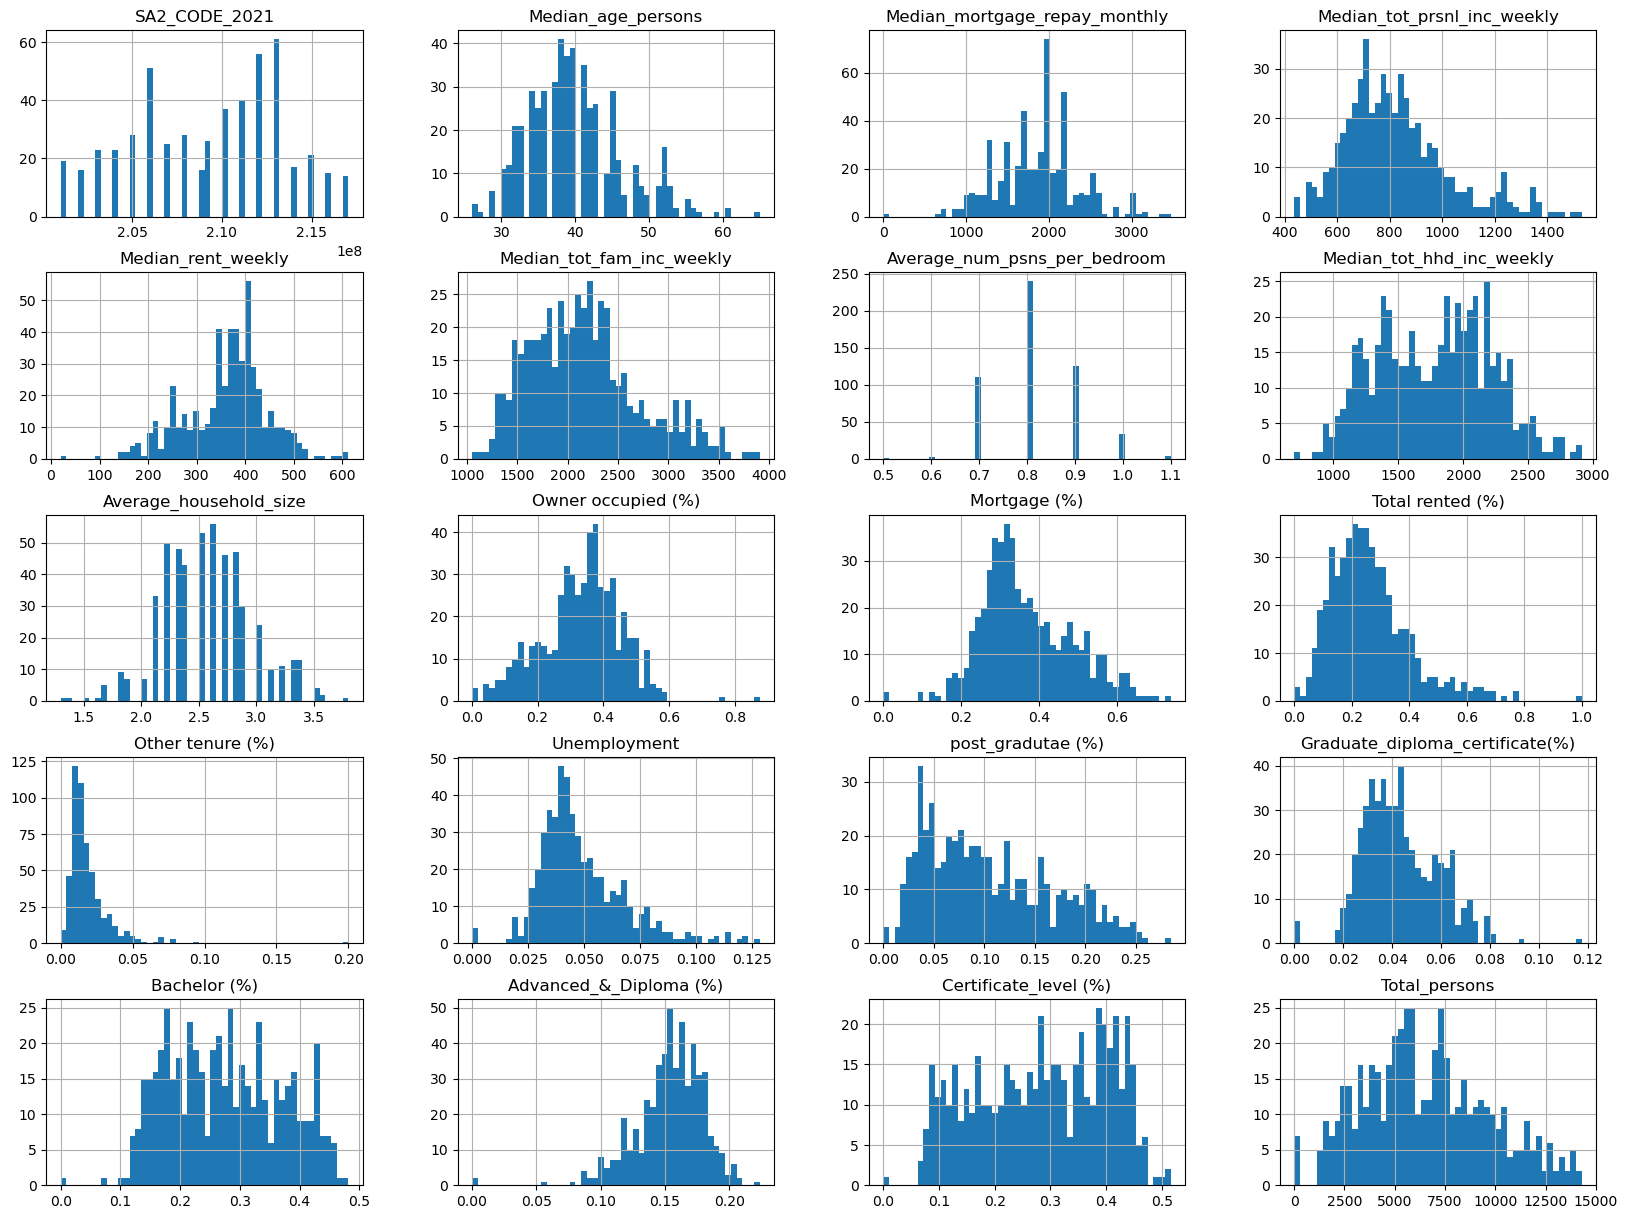

In [9]:
df_clean.hist(bins=50, figsize=(20,15))

Merging with shape file for geospatial analysis 

In [10]:
import geopandas as gpd

# Load shapefile
shp_path = "../data/landing/boundaries/SA2_2021_AUST_GDA2020.shp"
sa2 = gpd.read_file(shp_path)

# Rename 
sa2 = sa2.rename(columns={"SA2_CODE21": "SA2_CODE_2021"})

# Keep only selected geo columns + geometry
sa2 = sa2[["SA2_CODE_2021", "SA2_NAME21", "SA3_CODE21", "SA3_NAME21", "geometry"]]

# Ensure SA2 codes are string with zero padding
sa2["SA2_CODE_2021"] = sa2["SA2_CODE_2021"].astype(str).str.zfill(9)
df_clean["SA2_CODE_2021"] = df_clean["SA2_CODE_2021"].astype(str).str.zfill(9)

# Merge with census data
gdf = sa2.merge(df_clean, on="SA2_CODE_2021", how="inner")

print(gdf.head())
print(f"Merged rows: {len(gdf)}")

  SA2_CODE_2021     SA2_NAME21 SA3_CODE21 SA3_NAME21  \
0     201011001      Alfredton      20101   Ballarat   
1     201011002       Ballarat      20101   Ballarat   
2     201011005      Buninyong      20101   Ballarat   
3     201011006      Delacombe      20101   Ballarat   
4     201011007  Smythes Creek      20101   Ballarat   

                                            geometry  Median_age_persons  \
0  POLYGON ((143.78282 -37.56666, 143.75558 -37.5...                  34   
1  POLYGON ((143.81896 -37.55582, 143.81644 -37.5...                  45   
2  POLYGON ((143.84171 -37.61596, 143.84176 -37.6...                  42   
3  POLYGON ((143.7505 -37.59119, 143.75044 -37.59...                  33   
4  POLYGON ((143.73296 -37.62333, 143.73263 -37.6...                  41   

   Median_mortgage_repay_monthly  Median_tot_prsnl_inc_weekly  \
0                           1698                          865   
1                           1700                          842   
2          

/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_36000/1724340425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["SA2_CODE_2021"] = df_clean["SA2_CODE_2021"].astype(str).str.zfill(9)


In [11]:
# Save to GeoJSON
output_path = "../data/processed/demographics/sa2_census.geojson"
gdf.to_file(output_path, driver="GeoJSON")

print(f"GeoJSON saved to {output_path}")

GeoJSON saved to ../data/processed/demographics/sa2_census.geojson
